## Autoencoding drug assay images

In [12]:
%reset -f
from helpers.preprocess_data import *
%matplotlib inline

### Introduction

These images we taken of unknown drug compounds on assays for which it is unclear what is a successful outcome. The **red** channel stains the cell nuclei, and the **green** channel represents the GFP stained antibody. We understand that the GFP stained antibody situated around the edges of nuclei indicates a successful assay. An example image is displayed below.

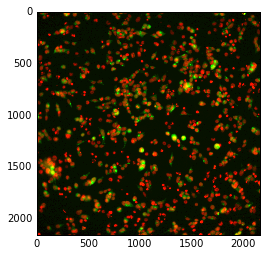

In [7]:
plt.imshow(p_image)

### Approach and progress

We have images of approximately 13000 such assays, along with the **labels for which assays were taken for further investigation**. We would like to have an idea of the image features which indicate assays that were taken forward for further screening.

- ~~Generate random image chunks~~
- ~~Training an autoencoder~~
- Extend to all assay images

Preprocessing steps and code are contained in `preprocess_data.py` and helper functions are defined in `helper.py`. Progress and explanations are detailed below.

## Generate random image chunks

It seems that the key features of the assay are spread quite evenly across the assay image. That is to say, any random rectangle of 100x100 pixels for example seems to capture the levels of red and green 'blobs' throughout the entire image. This is true even if the chunks are resized to quite low resolution. Below I display the full assay image along with a series of random series of 100x100 pixel squares which have randomly flipped and rotated according to the `random_chunk2()` function in `helpers.py`.

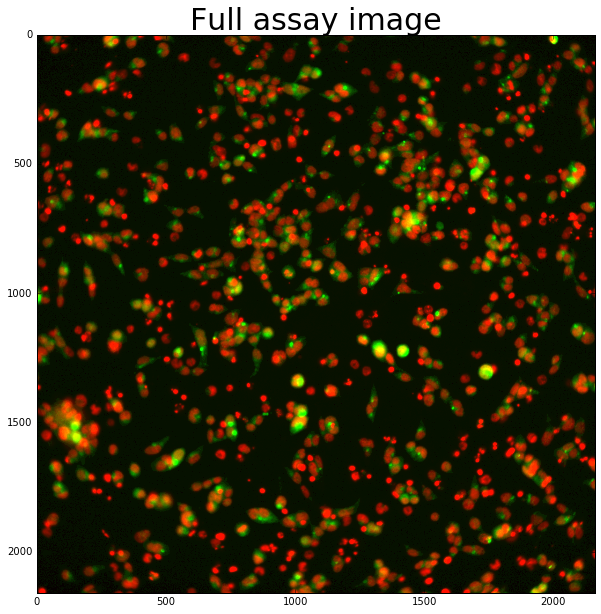

In [23]:
plt.figure(figsize=(10,10))
plt.title("Full Assay Image",size=30)
plt.imshow(p_image)

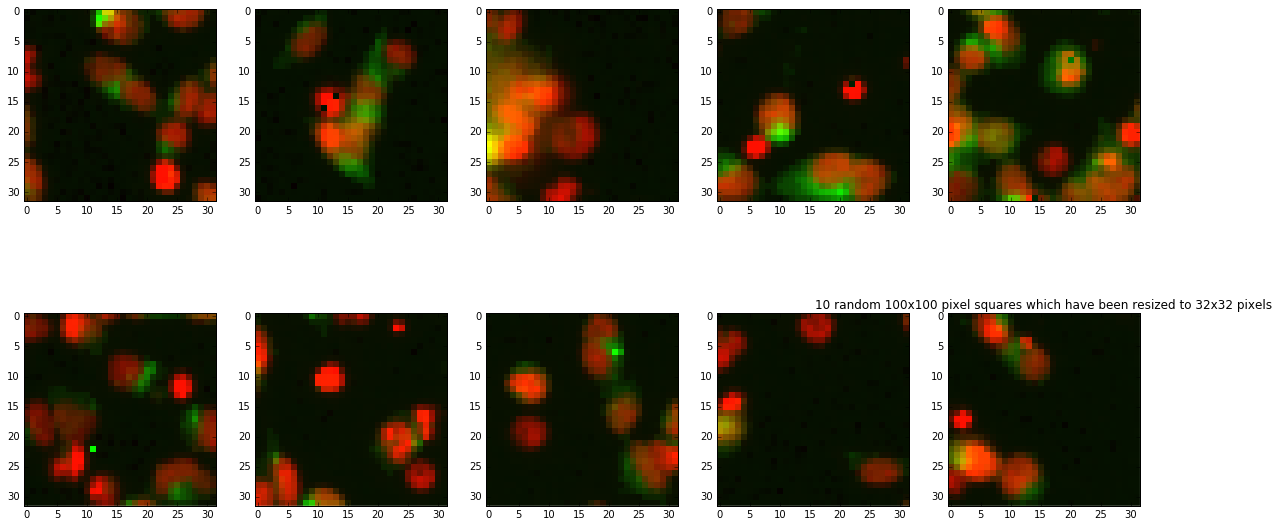

In [25]:
f, a = plt.subplots(2,5, figsize=(20,10))
plt.title("10 random 100x100 pixel squares which have been resized to 32x32 pixels")
for i in range(5):
    a[0][i].imshow(random_chunk2(p_image,100,32), interpolation='none')
    a[1][i].imshow(random_chunk2(p_image,100,32), interpolation='none')

## Training an autoencoder

In order to understand the complexity of the features within an image, it is helpful to create a compact representation of the data and then regenerate the images. For [example](http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf). Here I define an autoencoder with **2 convolutional layers** with filter size `[5,5]` and stride `[2,2]` and a fully-connected layer, along with the corresponding inverse deconvolutional and fully-connected layers. Note the absence of any max pooling operations or dropout. The code is contained in `autoencoder.py`. Currently the encoded images are vectors of length 100, therefore the compression is approximately 32x32x3 -> 100 ~ 30 times.

In [11]:
from helpers.autoencoder import *

I train the autoencoder for 100 epochs and compare the training images to it's encoded then decoded version. It is still able to extract many of the characteristics of the images with 30x compression and < 1 minute of training time. Experimenting with longer training time results in overfitting, and I have not yet investigated whether this improves with dropout.

Epoch:0001, cost=0.027090935
Epoch:0011, cost=0.019438634
Epoch:0021, cost=0.017914157
Epoch:0031, cost=0.009419256
Epoch:0041, cost=0.007441406
Epoch:0051, cost=0.005823840
Epoch:0061, cost=0.004621292
Epoch:0071, cost=0.003873670
Epoch:0081, cost=0.003888864
Epoch:0091, cost=0.003355247


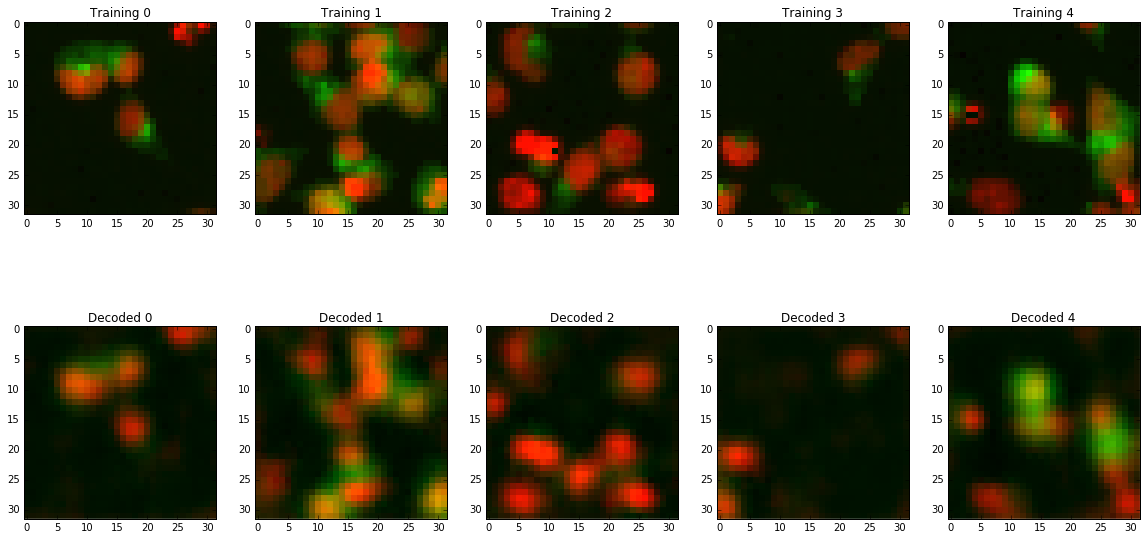

In [10]:
total_batch = len(train)
batch_size = 100
nbatches = total_batch / batch_size
training_epochs = 100
display_step = 10

with tf.Session() as sess:
    sess.run(init)
    for ep in range(training_epochs):
        for i in range(int(nbatches)):
            batch = train[batch_size*i: batch_size*(i+1)]
            _, c = sess.run([optimizer, cost], feed_dict={X: batch})
        if ep % display_step == 0:
            print "Epoch:" + '%04d' % (ep+1) + ', ' + "cost=" + "{:.9f}".format(c)
    encoded, decoded = sess.run(
        [encoder_op, decoder_op], feed_dict={X: train})
            

f, a = plt.subplots(2,5, figsize=(20,10))
for i in range(5):
    a[0][i].set_title("Training {}".format(i))
    a[0][i].imshow(train[i], interpolation='none')
    a[1][i].set_title("Decoded {}".format(i))
    a[1][i].imshow(multiply_with_overflow(decoded[i],[1,1,1]), interpolation='none')

### Possible future directions

From here there are a few potential things I can try and I would appreciate some input:
- Implement a t-SNE to cluster input images, perform some clustering of the encoded image vectors.
- Investigate / plot results of hidden layers.
- This is on a single image, extend to sample from all images, including both images that were taken forward and images that were not and investigate whether classification is possible.
- Something else entirely